<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019-grad-work/blob/CVX-1yr/CVX/daily1y/08_conv1d_multivar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Многомерная модель на 1D свёрточных слоях*

В качестве признаков используются цены, объём торгов и некоторое число индикаторов (всего 18 признаков)

In [1]:
import os
import glob
import datetime
import pickle

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from pandas_datareader import data as pdr

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
import tensorflow as tf
# tf.test.is_gpu_available()
tf.__version__

'2.0.0'

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (Input, Dense, Convolution1D, MaxPooling1D, Flatten,
                                     ReLU, LeakyReLU, Dropout, BatchNormalization)
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Nadam

In [7]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [8]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [9]:
INSTRUMENT = 'CVX' # Chevron corp
START_FROM = np.datetime64('today') - 7
WINDOW_SIZE = 60
FORECAST_OFFSET=1
BATCH_SIZE = 32
FORCE_TRAIN = True

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [10]:
instr = MarketData.create_from_alphavantage_intraday(INSTRUMENT, start=START_FROM)

In [11]:
instr.feature_names

['o',
 'h',
 'l',
 'c',
 'v',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14',
 'stochk',
 'stochd',
 'adline',
 'adosc']

Здесь не будем делить отдельно на тест и валидацию, поскольку данных у нас только 5 дней.

In [12]:
dates_unique = np.unique(instr.timestamps.astype('datetime64[D]'))

START_FROM = dates_unique[0]
VAL_TEST_SPLIT = dates_unique[-1]

START_FROM, VAL_TEST_SPLIT

(numpy.datetime64('2020-03-23'), numpy.datetime64('2020-03-27'))

## Целевая переменная

Цена закрытия.

In [13]:
orig_target = instr.c

In [14]:
def plot_transformed_series(instrument, series, orig_display_name, transformed_display_name):
    plotHelpers.plot_transformed_timeseries(
        instrument.instrument,
        series,
        title_orig = orig_display_name,
        xlabel_orig = 'Date',
        ylabel_orig = orig_display_name,
        title_transformed = transformed_display_name,
        xlabel_transformed = 'Date',
        ylabel_transformed = transformed_display_name
    )

Переходим к логарифмической доходности.

In [15]:
transformed_target = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

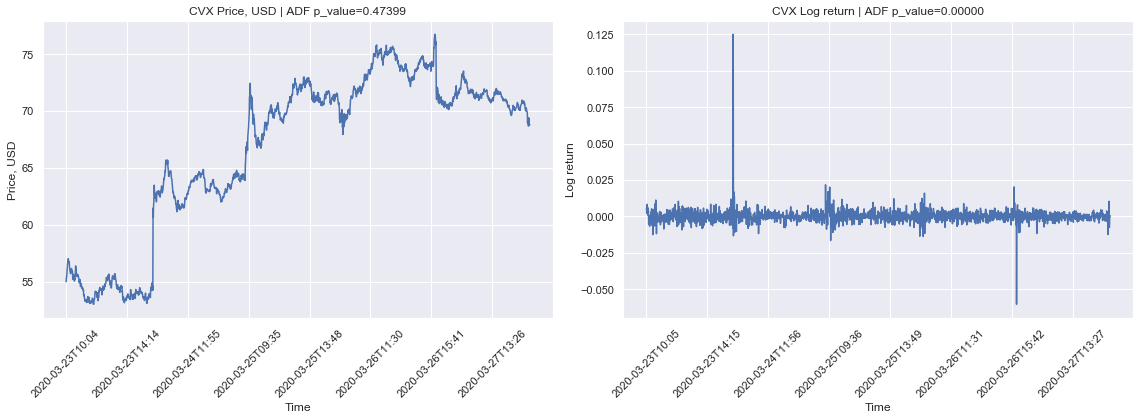

In [16]:
plotHelpers.plot_transformed_timeseries_unit(instr,
                                             transformed_target,
                                             'Price, USD', 'Log return',
                                             datetime_unit='m', rotation=45)

## Трансформация признаков

Приведение временных рядов к стационарности.

In [17]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'o': price_transformer(),
        'h': price_transformer(),
        'l': price_transformer(),
        'c': price_transformer(),
        'v': diff_transformer(1),
        'ema14': diff_transformer(1),
        'ema30': diff_transformer(1),
        'macd': identity_transformer(),
        'macd_signal': identity_transformer(),
        'rsi14': identity_transformer(),
        'bband20_upper': diff_transformer(1),
        'bband20_middle': diff_transformer(1),
        'bband20_lower': diff_transformer(1),
        'willr14': identity_transformer(),
        'stochd': identity_transformer(),
        'stochk': identity_transformer(),
        'adline': diff_transformer(1),
        'adosc': identity_transformer()
    }
    return feature_transformations

In [18]:
instr_transformed = instr.select_transform(make_feature_selector())

In [19]:
transformed_target = instr_transformed.c

## Обучающая, валидационная и тестовая выборки

In [20]:
instr_train, instr_test = instr_transformed.train_test_split(VAL_TEST_SPLIT, window_size=WINDOW_SIZE,
                                                             scaler=StandardScaler)
#                                                              scaler=MinMaxScaler,
#                                                              scaler_kwargs={'feature_range': (-1, 1)})

# instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_test)

(1519, 445)

Все отмасштабированные признаки на одном графике (для валидационного датасета):

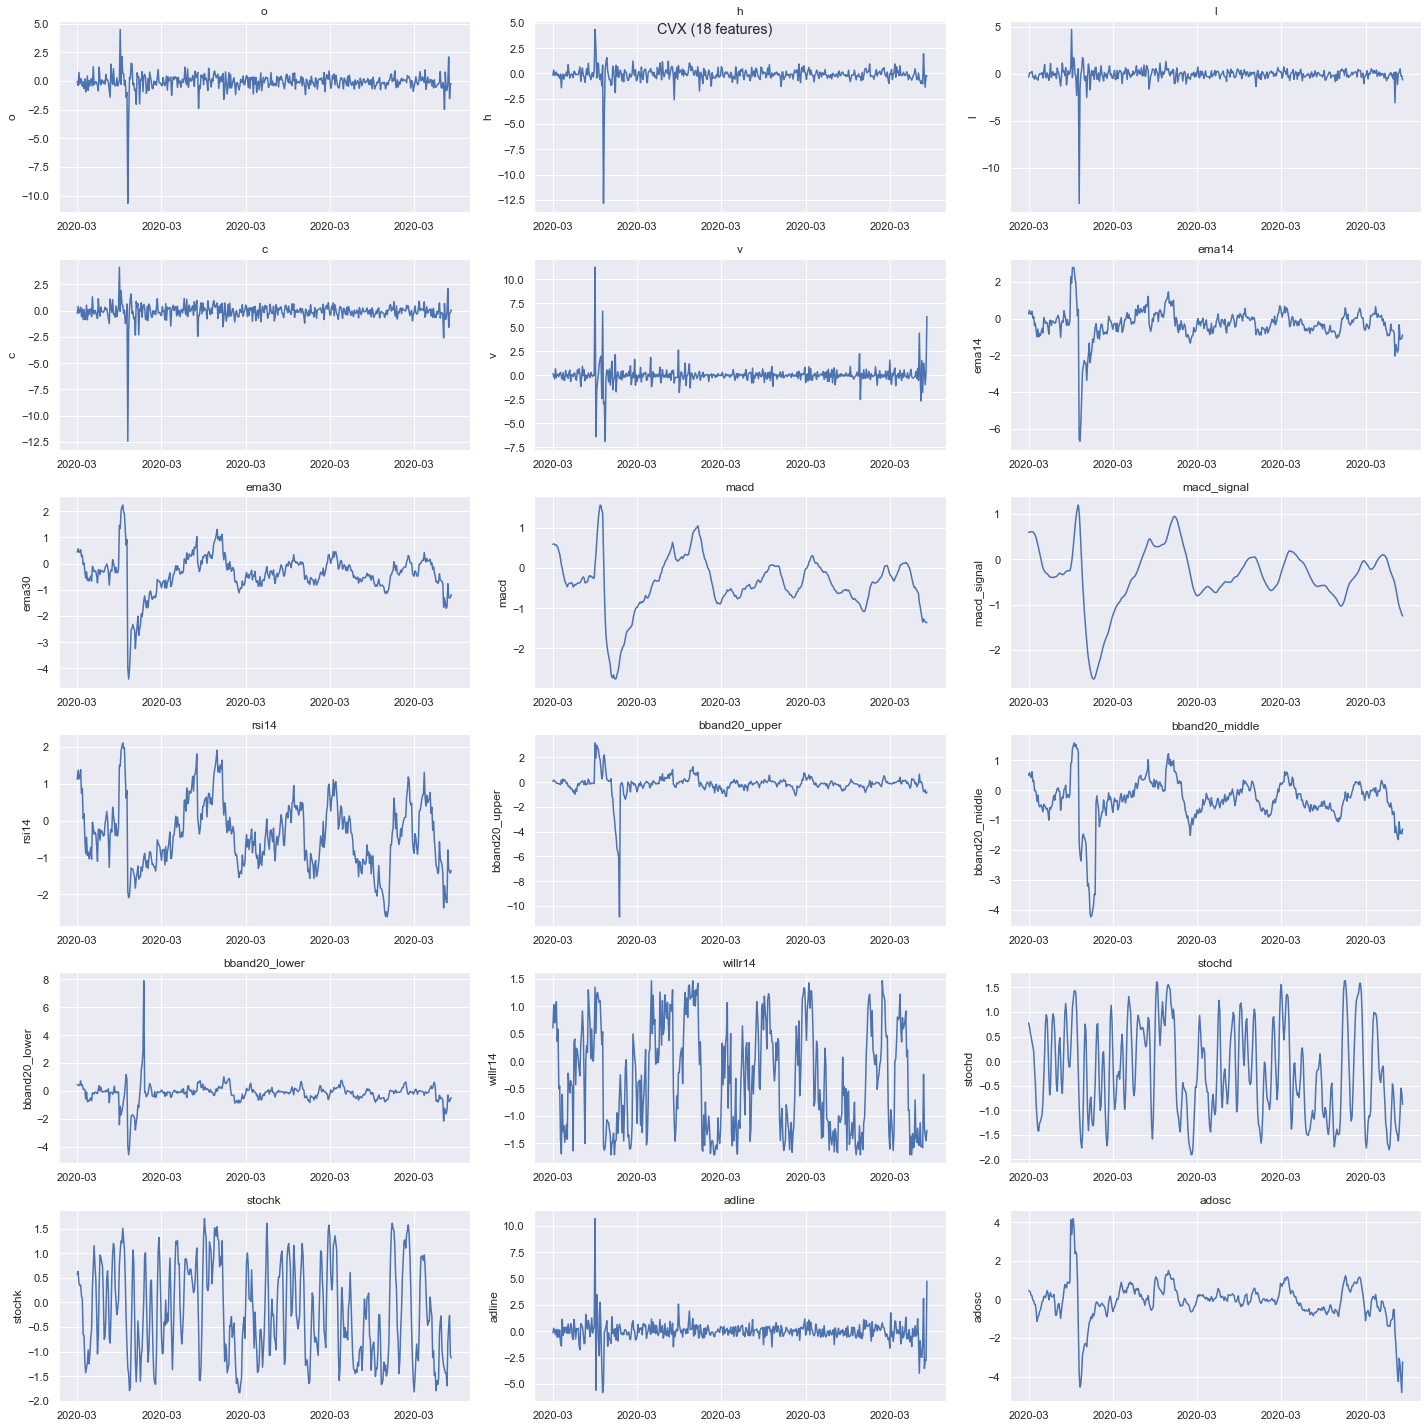

In [21]:
plotHelpers.plot_all_features(instr_test)

## Признаки - скользящие окна

In [22]:
train_mwf = MovingWindowFeatures.create(instr_train.c, [instr_train], instr_train.feature_names, window_size=WINDOW_SIZE)
# val_mwf = MovingWindowFeatures.create(instr_val.c, [instr_val], instr_val.feature_names, window_size=WINDOW_SIZE)
test_mwf = MovingWindowFeatures.create(instr_test.c, [instr_test], instr_test.feature_names, window_size=WINDOW_SIZE)

len(instr_train), len(train_mwf), train_mwf.features.shape

(1519, 1459, (1459, 60, 18))

Проверка, что скользящие окна соответствуют исходным данным.

Возьмём произвольный признак и произвольное окно (строка #**41**). Проверим, что данные в точности совпадают:

In [23]:
def check_data(md, mwf, row):
    col = np.random.randint(len(mwf.feature_names))
    feature = mwf.feature_names[col]
    check = (getattr(md, feature).data[row:row + mwf.window_size] == mwf.features[row, :, col]).all()
    assert check
    return feature, check

check_data(instr_train, train_mwf, 41)

('bband20_upper', True)

# *Модели*

Модель с двумя 1D свёрточными слоями.

In [24]:
def build_conv1d_layers(input_shape, filters=(16, 8), kernel_size=5, pool_size=2):
    # формат входа: наша матрица (окно; признак)
    inp = Input(input_shape, name='input')

    # стекаем два уровня Conv1D
    conv1d = Convolution1D(filters=filters[0],
                           kernel_size=kernel_size,
                           padding='same',
                           bias_initializer='he_uniform',
                           bias_regularizer=L1L2(0.01, 0.02),
                           kernel_regularizer=L1L2(0.01, 0.02)
                          )(inp)
    conv1d = BatchNormalization()(conv1d)
    conv1d = LeakyReLU()(conv1d)
    conv1d = Dropout(0.25)(conv1d)

    conv1d = Convolution1D(filters=filters[1],
                           kernel_size=kernel_size,
                           padding='same',
                           bias_initializer='he_uniform',
                           bias_regularizer=L1L2(0.01, 0.02),
                           kernel_regularizer=L1L2(0.01, 0.02)
                          )(conv1d)
    conv1d = BatchNormalization()(conv1d)
    conv1d = LeakyReLU()(conv1d)
    conv1d = Dropout(0.25)(conv1d)
    
    conv1d = MaxPooling1D(pool_size=pool_size)(conv1d)
    
    conv1d = Flatten()(conv1d)
    
    return inp, conv1d

#### Пути:

In [25]:
model_path_root = 'models'
model_type_name = 'conv1d_multivar'

def make_model_save_dir(path_root, type_name, class_name):
    save_dir = os.path.join(path_root, type_name, class_name)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

#### Общие коллбэки:

In [26]:
# уменьшение learning rate в случае, если loss не изменяется
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# уменьшение learning rate в 2 раза каждую 5-ю эпоху
def lr_decay(e, lr):
    return lr * (1 - 0.5 * (0 == (e + 1) % 5))

lr_scheduler = LearningRateScheduler(schedule=lr_decay, verbose=1)

## Задача регрессии

Непосредственное прогнозирование цены следующего периода.

In [27]:
train_regr_gen = RegressionGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_regr_gen = RegressionGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_regr_gen = RegressionGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

Следующие числа соответствуют значению параметра `steps_per_epoch` метода [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0") - то есть это число батчей, которые генератор выдаст за одну эпоху обучения (если класс генератора поддерживает метод `len()`, то данный параметр можно не указывать).

In [28]:
len(train_regr_gen), (test_regr_gen)

(46, <mdp.datasetGenerator.RegressionGenerator at 0x1bb7d6fcfc8>)

Один сэмпл данных представляет собой матрицу размером *(длина окна; число признаков)*

In [29]:
train_regr_gen.input_shape

(60, 18)

### Модель для задачи регрессии

In [30]:
model_class_name = 'regression'

In [31]:
def build_regression_model(input_shape):
    inp, conv1d = build_conv1d_layers(input_shape, filters=(32, 16))

    regr = Dense(32)(conv1d)
    regr = BatchNormalization()(regr)
    regr = LeakyReLU()(regr)
    regr = Dropout(0.25)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    return Model(inputs=[inp], outputs=[regr])

In [32]:
multivariate_regression_conv1d = build_regression_model(train_regr_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:
[`Nadam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) (*Adam with Nestrov momentum*).

In [33]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Дополнительные коллбэки:

In [34]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Функция потерь:

В качестве функции потерь будем использовать [MSE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) (чтобы штрафовать за большие отклонения). Xотя хорошая функция потерь в контексте темы данной задачи - это [вопрос сложный](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb). В частности, здесь нам, очевидно, помимо абсолютного значения отклонения также важен его знак.

In [35]:
multivariate_regression_conv1d.compile(optimizer=optimizer,
                                       loss={'regr': 'mse'},
                                       metrics={'regr': 'mae'})

multivariate_regression_conv1d.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 18)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 32)            2912      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 32)            128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 16)            2576      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 16)            64    

#### Обучение:

In [36]:
regr_history = utils.train_model(multivariate_regression_conv1d,
                                 model_save_dir, train_regr_gen, test_regr_gen,
                                 callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                 force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
45/46 [============================>.] - ETA: 0s - loss: 6.9616 - mae: 0.8610
Epoch 00001: val_loss improved from inf to 5.78144, saving model to models\conv1d_multivar\regression\01.hdf5
46/46 [==============================] - 8s 169ms/step - loss: 6.9578 - mae: 0.8633 - val_loss: 5.7814 - val_mae: 0.5004

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
45/46 [============================>.] - ETA: 0s - loss: 6.3108 - mae: 0.7535
Epoch 00002: val_loss improved from 5.78144 to 5.36111, saving model to models\conv1d_multivar\regression\02.hdf5
46/46 [==============================] - 8s 166ms/step - loss: 6.3138 - mae: 0.7560 - val_loss: 5.3611 - val_mae: 0.4736

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
45/46 [============================>.] - ETA: 0s - loss: 5.7047 - mae: 0.6948
Epoch 00003:

45/46 [============================>.] - ETA: 0s - loss: 2.8787 - mae: 0.5944
Epoch 00021: val_loss improved from 2.66444 to 2.64025, saving model to models\conv1d_multivar\regression\21.hdf5
46/46 [==============================] - 5s 114ms/step - loss: 2.8661 - mae: 0.5938 - val_loss: 2.6402 - val_mae: 0.4499

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
45/46 [============================>.] - ETA: 0s - loss: 2.8588 - mae: 0.5868
Epoch 00022: val_loss improved from 2.64025 to 2.62170, saving model to models\conv1d_multivar\regression\22.hdf5
46/46 [==============================] - 5s 119ms/step - loss: 2.8516 - mae: 0.5863 - val_loss: 2.6217 - val_mae: 0.4516

Epoch 00023: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 23/32
45/46 [============================>.] - ETA: 0s - loss: 2.8916 - mae: 0.5828
Epoch 00023: val_loss improved from 2.62170 to 2.59771, saving model to models\conv1d_multivar\regressio

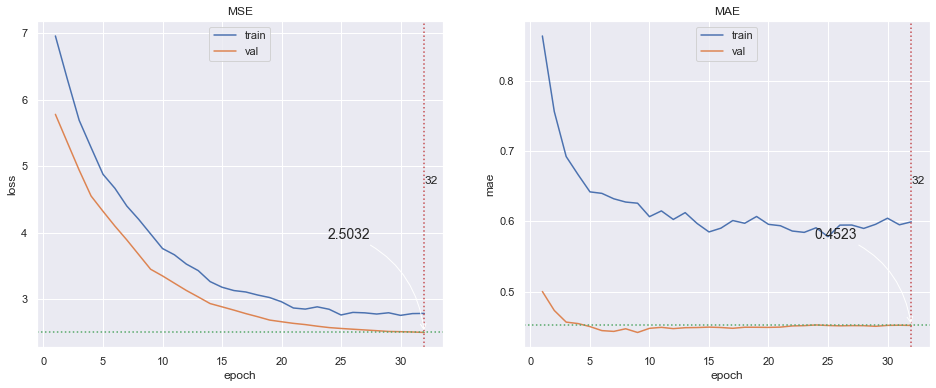

In [37]:
def plot_regr_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'MSE', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'MAE', 'mae', 'val_mae')
    
plot_regr_history(regr_history);

### Прогноз задачи регрессии

*Судя по всему, просто выходит на модель случайного блуждания*

In [38]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_regression_conv1d.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [39]:
pred_log_ret_test = multivariate_regression_conv1d.predict_generator(test_regr_gen, verbose=1)

13/13 [==============================] - 0s 24ms/step


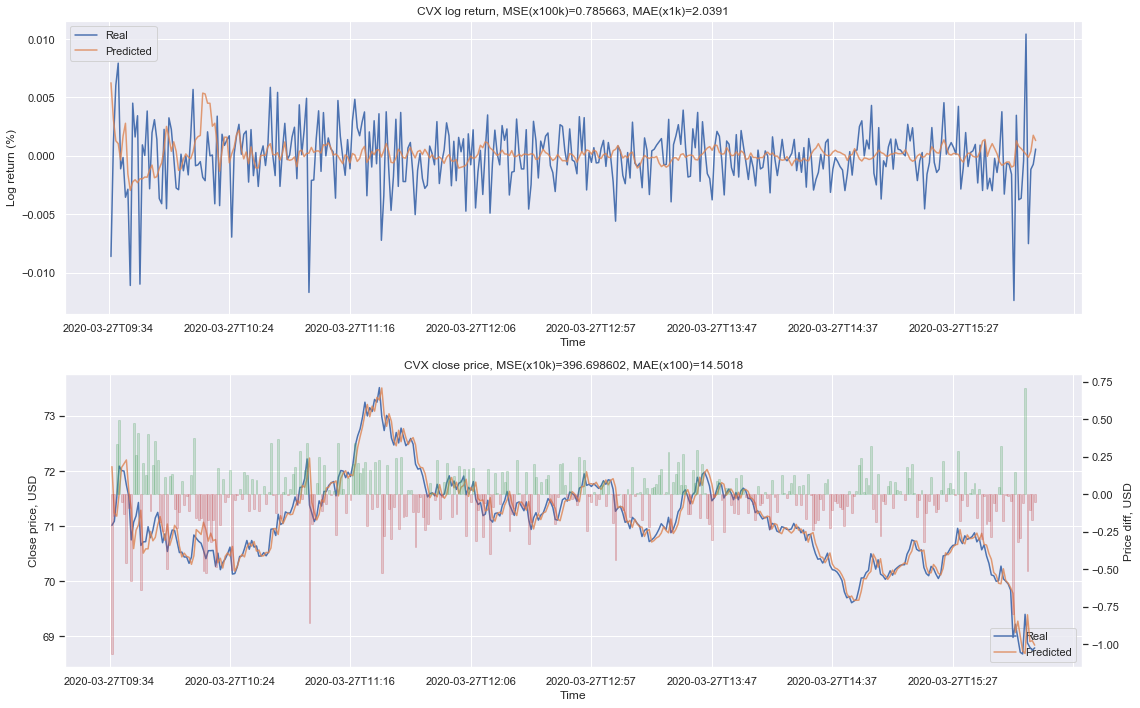

In [40]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 10),
                                  datetime_unit='m', xlabel='Time', plot_data_slice=slice(1, None))

## Задача классификации

Прогнозируем направление изменения цены по сравнению с предыдущим периодом (**0** - снижение, **1** - рост).

In [41]:
model_class_name = 'classification'

In [42]:
train_clf_gen = ClassificationGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_clf_gen = ClassificationGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_clf_gen = ClassificationGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
def build_classification_model(input_shape):
    inp, conv1d = build_conv1d_layers(input_shape, filters=(32, 16))

    clf = Dense(32)(conv1d)
    clf = BatchNormalization()(clf)
    clf = LeakyReLU()(clf)
    clf = Dropout(0.25)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)

    return Model(inputs=[inp], outputs=[clf])

In [44]:
multivariate_classification_conv1d = build_classification_model(test_clf_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [45]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [46]:
multivariate_classification_conv1d.compile(optimizer=optimizer,
                                           loss={'clf': 'binary_crossentropy'},
                                           metrics={'clf': 'accuracy'})

multivariate_classification_conv1d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 18)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 32)            2912      
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 32)            128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 60, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 16)            2576      
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 16)            64  

#### Дополнительные коллбэки:

In [47]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [48]:
clf_history = utils.train_model(multivariate_classification_conv1d,
                                model_save_dir, train_clf_gen, test_clf_gen,
                                callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
45/46 [============================>.] - ETA: 0s - loss: 5.5213 - accuracy: 0.5299
Epoch 00001: val_loss improved from inf to 4.76818, saving model to models\conv1d_multivar\classification\01.hdf5
46/46 [==============================] - 5s 118ms/step - loss: 5.5053 - accuracy: 0.5312 - val_loss: 4.7682 - val_accuracy: 0.4545

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
45/46 [============================>.] - ETA: 0s - loss: 4.1898 - accuracy: 0.5486
Epoch 00002: val_loss improved from 4.76818 to 3.58181, saving model to models\conv1d_multivar\classification\02.hdf5
46/46 [==============================] - 6s 121ms/step - loss: 4.1794 - accuracy: 0.5483 - val_loss: 3.5818 - val_accuracy: 0.4961

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
45/46 [============================>.] - ETA: 0s - l

45/46 [============================>.] - ETA: 0s - loss: 0.8578 - accuracy: 0.6021
Epoch 00020: val_loss improved from 0.93179 to 0.92333, saving model to models\conv1d_multivar\classification\20.hdf5
46/46 [==============================] - 6s 120ms/step - loss: 0.8579 - accuracy: 0.6018 - val_loss: 0.9233 - val_accuracy: 0.5039

Epoch 00021: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 21/32
45/46 [============================>.] - ETA: 0s - loss: 0.8378 - accuracy: 0.6139
Epoch 00021: val_loss improved from 0.92333 to 0.91753, saving model to models\conv1d_multivar\classification\21.hdf5
46/46 [==============================] - 6s 120ms/step - loss: 0.8403 - accuracy: 0.6127 - val_loss: 0.9175 - val_accuracy: 0.5013

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
45/46 [============================>.] - ETA: 0s - loss: 0.8378 - accuracy: 0.6042
Epoch 00022: val_loss improved from 0.91753 to 0.90828, savin

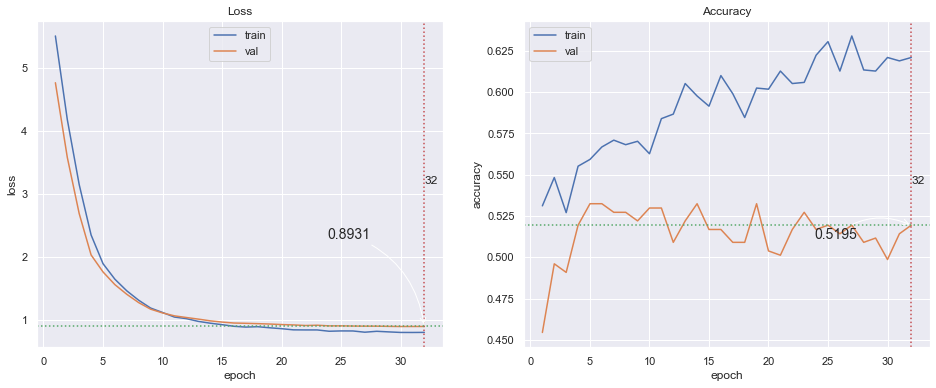

In [49]:
def plot_clf_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'Loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'Accuracy', 'accuracy', 'val_accuracy')
    
plot_clf_history(clf_history);

### Прогноз задачи классификации

In [50]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_classification_conv1d.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

In [51]:
pred_direction_proba = multivariate_classification_conv1d.predict_generator(test_clf_gen, verbose=1)

true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

13/13 [==============================] - 0s 24ms/step


0.46737462

In [52]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([207, 178], dtype=int64)),
 (array([0, 1]), array([207, 178], dtype=int64)))

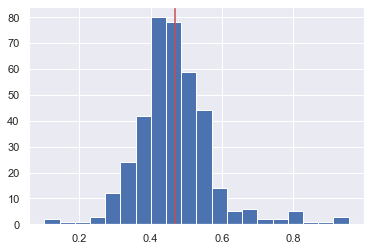

In [53]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [54]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       207
           1       0.44      0.44      0.44       178

    accuracy                           0.48       385
   macro avg       0.48      0.48      0.48       385
weighted avg       0.48      0.48      0.48       385



In [55]:
confusion_matrix(true_direction, predicted_direction)

array([[107, 100],
       [100,  78]], dtype=int64)

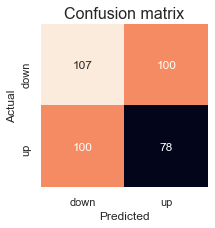

array([[0.51690821, 0.56179775],
       [0.48309179, 0.43820225]])

In [56]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

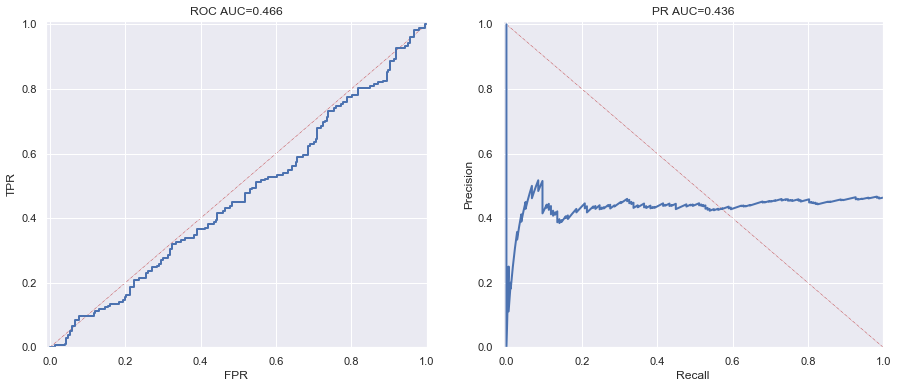

In [57]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## Многозадачная модель: одновременно регрессия и классификация

In [58]:
model_class_name = 'multitask'

In [59]:
train_multi_gen = MultitaskGenerator.create(train_mwf, batch_size=BATCH_SIZE)
# val_multi_gen = MultitaskGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_multi_gen = MultitaskGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [60]:
def build_multitask_model(input_shape):
    inp, conv1d = build_conv1d_layers(input_shape, filters=(32, 16))

    # первый выход: задача регрссии
    regr = Dense(32)(conv1d)
    regr = BatchNormalization()(regr)
    regr = LeakyReLU()(regr)
    regr = Dropout(0.25)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    # второй выход: задача классификации
    clf = Dense(32)(conv1d)
    clf = BatchNormalization()(clf)
    clf = LeakyReLU()(clf)
    clf = Dropout(0.25)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)
    
    return Model(inputs=[inp], outputs=[regr, clf])

In [61]:
multivariate_multitask_conv1d = build_multitask_model(train_multi_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [62]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [63]:
multivariate_multitask_conv1d.compile(optimizer=optimizer,
                                      loss={'regr': 'mse', 'clf': 'binary_crossentropy'},
                                      loss_weights={'regr': 1., 'clf': 1.},
                                      metrics={'regr': 'mae', 'clf' : 'accuracy'})

multivariate_multitask_conv1d.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 60, 18)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 60, 32)       2912        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 60, 32)       128         conv1d_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 60, 32)       0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

#### Дополнительные коллбэки:

In [64]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [65]:
multitask_history = utils.train_model(multivariate_multitask_conv1d,
                                      model_save_dir, train_multi_gen, test_multi_gen,
                                      callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                      force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
45/46 [============================>.] - ETA: 0s - loss: 7.7424 - regr_loss: 1.8343 - clf_loss: 0.7858 - regr_mae: 0.8880 - clf_accuracy: 0.4903
Epoch 00001: val_loss improved from inf to 6.43337, saving model to models\conv1d_multivar\multitask\01.hdf5
46/46 [==============================] - 8s 164ms/step - loss: 7.7247 - regr_loss: 1.8215 - clf_loss: 0.7841 - regr_mae: 0.8874 - clf_accuracy: 0.4907 - val_loss: 6.4334 - val_regr_loss: 0.7244 - val_clf_loss: 0.7463 - val_regr_mae: 0.4930 - val_clf_accuracy: 0.4701

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
45/46 [============================>.] - ETA: 0s - loss: 7.0428 - regr_loss: 1.4975 - clf_loss: 0.7420 - regr_mae: 0.7863 - clf_accuracy: 0.5243
Epoch 00002: val_loss improved from 6.43337 to 6.04444, saving model to models\conv1d_multivar\multitask\02.hdf5
46/46 [======================

45/46 [============================>.] - ETA: 0s - loss: 4.1775 - regr_loss: 1.1167 - clf_loss: 0.6725 - regr_mae: 0.6326 - clf_accuracy: 0.5910
Epoch 00014: val_loss improved from 3.84961 to 3.75790, saving model to models\conv1d_multivar\multitask\14.hdf5
46/46 [==============================] - 7s 159ms/step - loss: 4.1677 - regr_loss: 1.1062 - clf_loss: 0.6741 - regr_mae: 0.6332 - clf_accuracy: 0.5881 - val_loss: 3.7579 - val_regr_loss: 0.7120 - val_clf_loss: 0.7068 - val_regr_mae: 0.4545 - val_clf_accuracy: 0.4805

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0001250000059371814.
Epoch 15/32
45/46 [============================>.] - ETA: 0s - loss: 4.0539 - regr_loss: 1.0597 - clf_loss: 0.6787 - regr_mae: 0.6198 - clf_accuracy: 0.5764
Epoch 00015: val_loss improved from 3.75790 to 3.70563, saving model to models\conv1d_multivar\multitask\15.hdf5
46/46 [==============================] - 7s 154ms/step - loss: 4.0475 - regr_loss: 1.0513 - clf_loss: 0.6812 - regr_mae:

45/46 [============================>.] - ETA: 0s - loss: 3.2576 - regr_loss: 0.6357 - clf_loss: 0.6665 - regr_mae: 0.5985 - clf_accuracy: 0.5750
Epoch 00027: val_loss improved from 3.39467 to 3.38429, saving model to models\conv1d_multivar\multitask\27.hdf5
46/46 [==============================] - 7s 161ms/step - loss: 3.9054 - regr_loss: 1.2885 - clf_loss: 0.6673 - regr_mae: 0.6138 - clf_accuracy: 0.5757 - val_loss: 3.3843 - val_regr_loss: 0.7306 - val_clf_loss: 0.7036 - val_regr_mae: 0.4576 - val_clf_accuracy: 0.5039

Epoch 00028: LearningRateScheduler reducing learning rate to 3.125000148429535e-05.
Epoch 28/32
45/46 [============================>.] - ETA: 0s - loss: 3.6461 - regr_loss: 1.0350 - clf_loss: 0.6660 - regr_mae: 0.6051 - clf_accuracy: 0.5951
Epoch 00028: val_loss improved from 3.38429 to 3.37633, saving model to models\conv1d_multivar\multitask\28.hdf5
46/46 [==============================] - 7s 157ms/step - loss: 3.6439 - regr_loss: 1.0313 - clf_loss: 0.6676 - regr_mae:

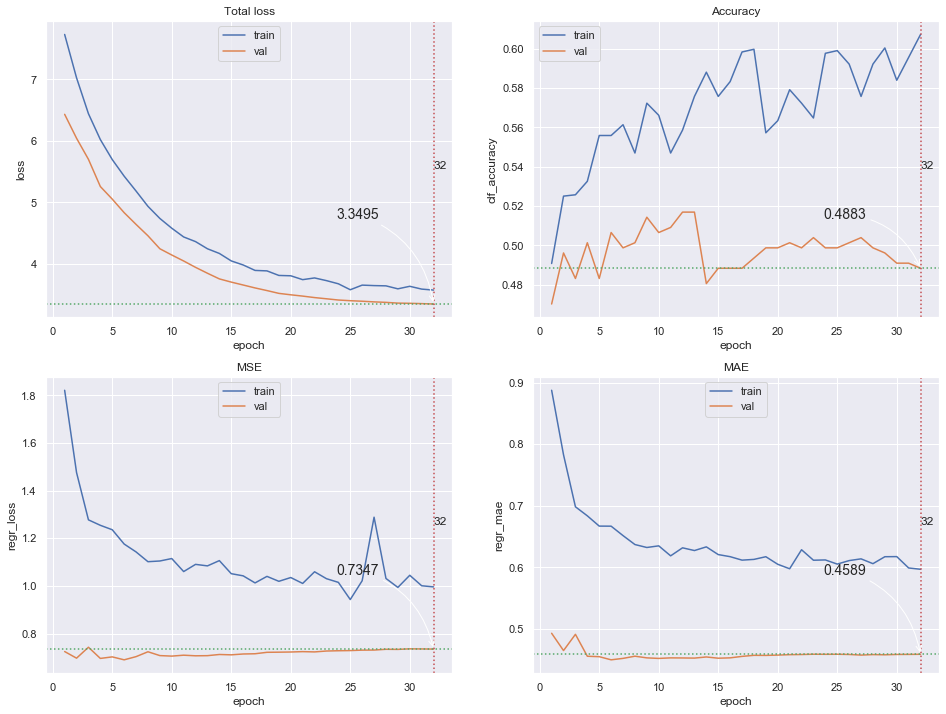

In [66]:
def plot_multitask_history(hist):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plotHelpers.plot_train_history(ax[0, 0], hist, 'Total loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[0, 1], hist, 'Accuracy', 'clf_accuracy', 'val_clf_accuracy')
    plotHelpers.plot_train_history(ax[1, 0], hist, 'MSE', 'regr_loss', 'val_regr_loss')
    plotHelpers.plot_train_history(ax[1, 1], hist, 'MAE', 'regr_mae', 'val_regr_mae')
    
plot_multitask_history(multitask_history);

### Прогноз

In [67]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_multitask_conv1d.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [68]:
pred_log_ret, pred_direction_proba = multivariate_multitask_conv1d.predict_generator(test_multi_gen, verbose=1)

13/13 [==============================] - 0s 30ms/step


In [69]:
np.set_printoptions(precision=3, suppress=True)

np.column_stack([pred_log_ret, pred_direction_proba])[-10:]

array([[-0.292,  0.427],
       [ 0.089,  0.506],
       [ 0.025,  0.48 ],
       [ 0.011,  0.516],
       [ 0.132,  0.534],
       [ 0.027,  0.422],
       [ 0.03 ,  0.496],
       [ 0.133,  0.522],
       [ 0.156,  0.45 ],
       [ 0.397,  0.576]], dtype=float32)

#### Прогноз задачи регрессии

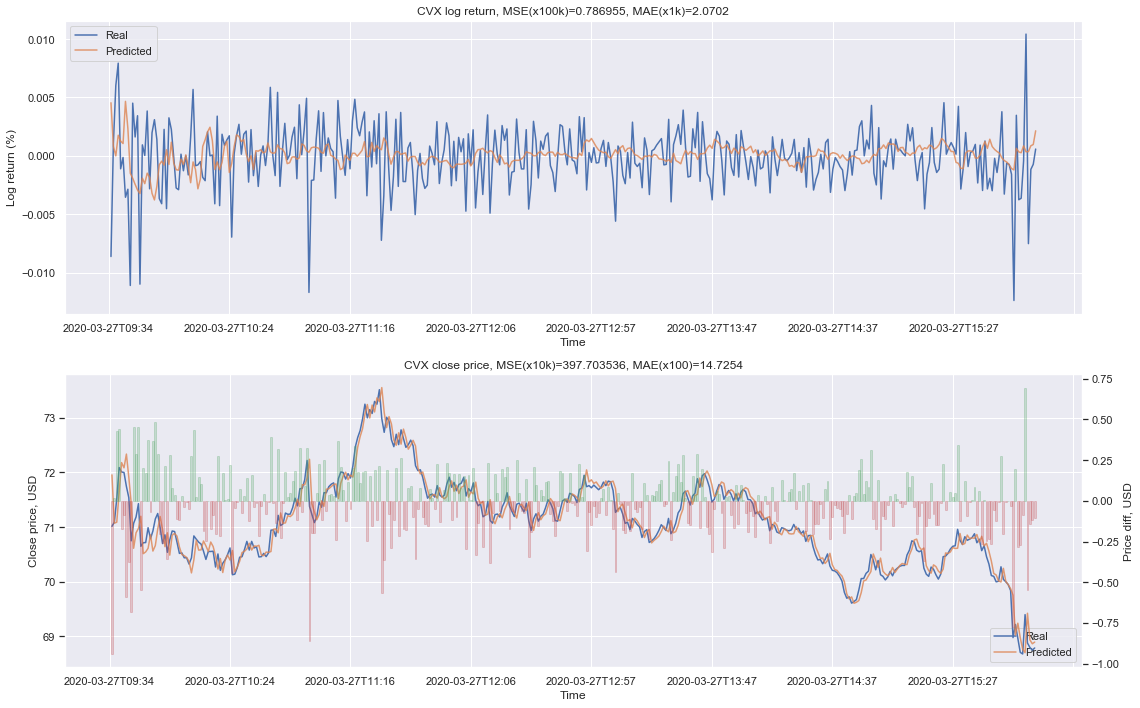

In [70]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret, figsize=(16, 10),
                                  datetime_unit='m', xlabel='Time', plot_data_slice=slice(1, None))

#### Прогноз задачи классификации

In [71]:
true_direction = test_multi_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

0.4740685

In [72]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([207, 178], dtype=int64)),
 (array([0, 1]), array([210, 175], dtype=int64)))

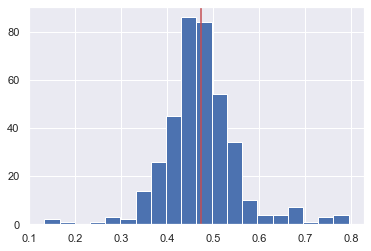

In [73]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [74]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.51      0.52      0.52       207
           1       0.43      0.43      0.43       178

    accuracy                           0.48       385
   macro avg       0.47      0.47      0.47       385
weighted avg       0.48      0.48      0.48       385



In [75]:
confusion_matrix(true_direction, predicted_direction)

array([[108,  99],
       [102,  76]], dtype=int64)

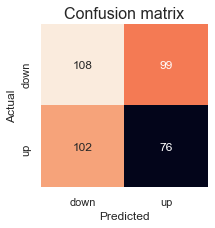

array([[0.514, 0.566],
       [0.486, 0.434]])

In [76]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

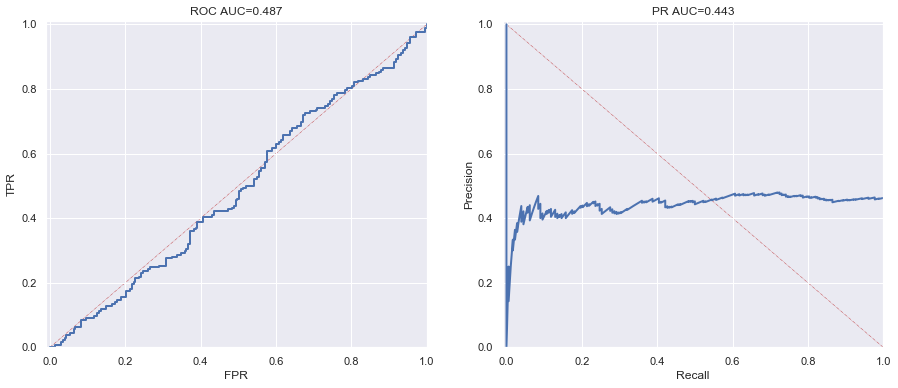

In [77]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

# Выводы

1.  Модель с 1D свёртками обучается гораздо быстрее модели LSTM
2.  Задача классификации не решается удовлетворительно.
